# Carregamento e preparação de *datasets*

O carregamento e preparação de *datasets* é um ótimo exercício para tomarmos conhecimento das ferramentas a serem utilizadas para o processamento de sinais em `python`, seja sinais biológicos quanto de outra natureza, como um som, corrente elétrica, etc.

Nesta `notebook` será apresentado o carregamento de um *dataset* público do *website* `UCI - Machine Learning Repository`. O *dataset* a ser utilizado é o `EEG Database Data Set` (https://archive.ics.uci.edu/ml/datasets/EEG+Database).


## Descrição do *dataset*:

A intenção deste *dataset* é examinar por meio de algoritmos de inteligência computacional a pré-disposição genética que um paciente possui ao alcoolismo.

Os principais dados analizados são do tipo *time-series*, em outras palavras, conjuntos de dados que representam um sinal mensurado no domínio do tempo. Os dados são completados com outros atributos como o nome do eletrodo, o número da amostra, etc. Outras informações relevantes do *dataset*:

- Quantidade de atributos: 4
- Número de instancias: 122
- Existem dados faltantes? Sim
- Tipos de dados encontrados: categórico, inteiro e real

Existem três categorias de dados neste *dataset*:

1. Small Data Set: <font color='red'>**descrever**</font>
2. Large Data Set: <font color='red'>**descrever**</font>
3. Full Data Set: <font color='red'>**descrever**</font>

Cada sessão (*trial*) é armazenada da seguinte forma:

```
# co2a0000364.rd 
# 120 trials, 64 chans, 416 samples 368 post_stim samples 
# 3.906000 msecs uV 
# S1 obj , trial 0 
# FP1 chan 0 
0 FP1 0 -8.921 
0 FP1 1 -8.433 
0 FP1 2 -2.574 
0 FP1 3 5.239 
0 FP1 4 11.587 
0 FP1 5 14.028
...
```

As primeiras 4 linhas são de cabeçalho:

**linha 1**: identificação do paciente e se ele indica ser um alcoólatra (a) ou controle (c) pela quarta letra (co2**a**0000364);

**linha 4**: determina se o paciente foi exposto a um único estímulo (`S1 obj`), a dois estímulos iguais (`S2 match`) ou a dois estímulos diferentes (`S2 no match`);

**linha 5**: identifica o início da coleta dos dados pelo eletrodo FP1. As 4 colunas são:

```
número_da_sessão identificação_do_eletrodo número_da_amostra valor_em_micro_volts
```


### Realizando o download 

Primeiro faremos um código para verificar se o *dataset* já foi baixado, caso contrário, executar o código de download:

In [1]:
from urllib.request import urlopen, urlretrieve
import os


urls = {
    'small': 'https://archive.ics.uci.edu/ml/machine-learning-databases/eeg-mld/smni_eeg_data.tar.gz',
    'large_train': 'https://archive.ics.uci.edu/ml/machine-learning-databases/eeg-mld/SMNI_CMI_TRAIN.tar.gz',
    'large_test': 'https://archive.ics.uci.edu/ml/machine-learning-databases/eeg-mld/SMNI_CMI_TEST.tar.gz',
    'full': 'https://archive.ics.uci.edu/ml/machine-learning-databases/eeg-mld/eeg_full.tar'
}

# verifica se o diretório dos datasets existe
if not os.path.exists('dataset/'):
    os.mkdir('dataset/')
    for k, v in urls.items():
        fn = v.split('/')[-1]
        print('Baixando:', fn, '...')
        urlretrieve(v, './dataset/{}'.format(fn))
    print('Downlod dos datasets concluído!')
else:
    print('Dataset já baixado!')

Dataset já baixado!


### Descompactando pastas e subpastas

Agora é necessário descompactar (recursivamente) diversas pastas e subpastas em arquivos GZip. Algumas pastas estão com o arquivo na extensão `.tar`, já outras, `.tar.gz`. Não obstante, algumas subpastas estão compactadas e outras não.

In [2]:
from subprocess import getoutput as gop
import glob


# único arquivo somente empacotado (tar)
os.mkdir('dataset/eeg_full/')
gop('tar -xvf dataset/eeg_full.tar -C dataset/eeg_full')
os.remove('dataset/eeg_full.tar')

while glob.glob('dataset/**/*.gz', recursive=True):
    # quando o arquivo está empacotado (tar) e compactado (gz)
    for f in glob.iglob('dataset/**/*.tar.gz', recursive=True):
        gop('tar -zxvf {} -C {}'.format(f, f[:f.rindex('/')]))
        os.remove(f)
    # quando o arquivo está somente compactado (gz)
    for f in glob.iglob('dataset/**/*.gz', recursive=True):
        gop('gzip -d {}'.format(f))
print('Descompactações finalizadas!')

FileNotFoundError: [Errno 2] No such file or directory: 'dataset/eeg_full.tar'

### Carregando parte do dataset

Vamos agora carregar o subconjunto "small" do *dataset* e fica como <font color='red'>**tarefa de casa**</font> carregar e preparar todos os outros subconjuntos...

In [3]:
# organizando melhor as pastas
os.rename('dataset/smni_eeg_data', 'dataset/small')
os.rename('dataset/eeg_full', 'dataset/full')
os.rename('dataset/SMNI_CMI_TRAIN/', 'dataset/large_train/')
os.rename('dataset/SMNI_CMI_TEST/', 'dataset/large_test/')
print(gop('ls -l dataset/'))

total 32
drwxr-xr-x 124 rhubner rhubner 4096 abr 20 20:47 full
drwxr-xr-x  22 rhubner rhubner 4096 out  5  1997 large_test
drwxr-xr-x  22 rhubner rhubner 4096 out  5  1997 large_train
drwxr-xr-x   8 rhubner rhubner 4096 abr 20 20:47 small


In [4]:
from re import search
import numpy as np

# identificando pastas
folders = {
    'small': 'dataset/small',
    'large_train': 'dataset/large_train',
    'large_test': 'dataset/large_test',
    'full': 'dataset/full',
}
# carregando pasta "small"
small_dir = gop('ls {}'.format(folders['small'])).split('\n')
# 1ª dimensão dos dados contendo os sujeitos. Ex.: C_1, a_m, etc
subjects = list()
for types in small_dir:
    files = gop('ls {}/{}'.format(folders['small'], types)).split('\n')
    # 2ª dimensão dos dados contendo as sessões (trials)
    trials = list()
    for f in files:
        arquivo = open('{}/{}/{}'.format(folders['small'], types, f))
        text = arquivo.readlines()
        # 3ª dimensão dos dados contendo os canais (eletrodos)
        chs = list()
        # 4ª dimensão dos dados contendo os valores em milivolts
        values = list()
        for line in text:
            # ex: "# FP1 chan 0"
            t = search('\w{1,3} chan \d{1,2}', line)
            # ex: "0 FP1 0 -8.921"
            p = search('^\d{1,2}\ \w{1,3}\ \d{1,3}\ (?P<value>.+$)', line)
            if p:
                values.append(float(p.group('value')))
            # mudou para outro eletrodo
            elif t and values:
                chs.append(values)
                values = list()
        chs.append(values)
        trials.append(chs)
        arquivo.close()
    subjects.append(trials)
data = np.array(subjects)
print(data.shape)

(6, 10, 64, 256)


### Dados carregados...

Os dados "single" foram dividos da seguinte forma:
```
[experimentos, triagens, canais, amostras]
```
formando um `numpy.array` de quatro dimensões.

Em seguida, vamos plotar esses dados para "tentar" visualizar algum padrão.

(16384, 3)


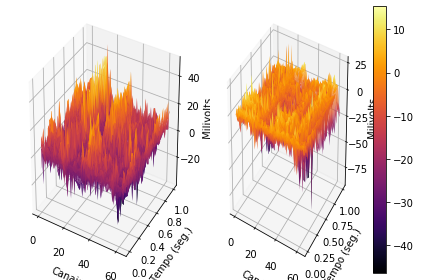

In [8]:
%matplotlib inline

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

d1 = list()
d2 = list()

for e in range(64):
    for i, t in enumerate(np.linspace(0, 1, 256)):
        d1.append([e, t, data[0][0][e][i]])
        d2.append([e, t, data[1][0][e][i]])
d1 = np.array(d1)
d2 = np.array(d2)
print(d1.shape)
x1, y1, z1 = d1[:,0], d1[:,1], d1[:,2]
x2, y2, z2 = d2[:,0], d2[:,1], d2[:,2]

fig = plt.figure()

ax = fig.add_subplot(1, 2, 1, projection='3d')
surf = ax.plot_trisurf(x1, y1, z1, cmap=cm.inferno, linewidth=1)
ax.set_xlabel('Canais')
ax.set_ylabel('Tempo (seg.)')
ax.set_zlabel('Milivolts')

ax = fig.add_subplot(1, 2, 2, projection='3d')
surf = ax.plot_trisurf(x2, y2, z2, cmap=cm.inferno, linewidth=1)
ax.set_xlabel('Canais')
ax.set_ylabel('Tempo (seg.)')
ax.set_zlabel('Milivolts')

fig.colorbar(surf)
fig.tight_layout()
plt.show()

### Continuação...

- Melhorar os comentários no códigos
- Modificar a visualização do gráfico **de** um *trial* fixo **para** a média de todos os *trials*
    - Fatorar o código o máximo possível (evitar loops desnecessários com o uso de `numpy`
    - Criar mais `subplots` para comparar a visualização
- Gravar os dados carregados em arquivo(s) CSV de um jeito mais fácil de carregar novamente
- Fazer o código para os arquivos "large": os arquivos estão divididos em **treino** e **teste** (próximo passo do curso)